# SCOPによる制約最適化

## 変数
- $x_{ik}$ $x_{jl}$ : 人iが避難施設kに避難した場合に１　バイナリー変数

## 定数

- $D_{kl}$ : 避難施設kとlの間に定義される伝染危険率
    - 二つの距離が近いと大きい

- $W_{ij} $ : 人i,jでの伝染危険率(以下の二つの重み付き自乗和)

    - 感染の差の自乗とmax(jの感染率 – iの感染率,0)・iの死亡率 + max(iの感染率 – jの感染率,0)・ jの死亡率
    - 感染率の差の自乗
    
- $C_{ik} $ : 人iと避難施設kの間に定義されるユークリッド距離

## 目的関数
-  min $\sum_{ijkl}^{} W_{ij} D_{kl}  x_{ik}  x_{jl}$

## 制約
- すべての人 iに対して，x[i,k]の施設kに対する合計 = 1   

- 施設kに対してx[i]=kの人に対する合計が施設kの容量以下

## 必要な集合
- 人の集合 people
- 人の感染率の集合 infec_rate
- 人の死亡率の集合 mort_rate
- 施設集合 shelters
- 施設の位置情報 locations
- 施設の容量 capacity

In [58]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
#random.seed(1)
np.random.seed(2)

In [59]:
N = 50 #人の数
people = [i for i in range(N)] #人の集合
infec_rate,mort_rate = {},{}
x_y= np.random.rand(N, 2) * 100
for i in people:
    if i < 5:
        infec_rate[i] = random.randint(0,10)
        mort_rate[i] = random.randint(90,100)
    elif 5 <= i < 11:
        infec_rate[i] = random.randint(90,100)
        mort_rate[i] = random.randint(0,10)
    elif 11 <= i < 16:
        infec_rate[i] = random.randint(90,100)
        mort_rate[i] = random.randint(90,100)
    else:
        infec_rate[i] = random.randint(0,10)
        mort_rate[i] = random.randint(0,10)
print(infec_rate)
print(mort_rate)

{0: 0, 1: 5, 2: 1, 3: 6, 4: 1, 5: 100, 6: 100, 7: 91, 8: 98, 9: 100, 10: 100, 11: 97, 12: 96, 13: 92, 14: 95, 15: 92, 16: 5, 17: 2, 18: 2, 19: 4, 20: 2, 21: 4, 22: 10, 23: 6, 24: 3, 25: 10, 26: 0, 27: 9, 28: 2, 29: 0, 30: 7, 31: 10, 32: 9, 33: 6, 34: 8, 35: 6, 36: 3, 37: 7, 38: 5, 39: 6, 40: 10, 41: 4, 42: 6, 43: 5, 44: 5, 45: 5, 46: 3, 47: 4, 48: 0, 49: 2}
{0: 92, 1: 91, 2: 95, 3: 94, 4: 99, 5: 9, 6: 1, 7: 3, 8: 2, 9: 0, 10: 10, 11: 100, 12: 94, 13: 96, 14: 93, 15: 96, 16: 4, 17: 0, 18: 6, 19: 10, 20: 10, 21: 4, 22: 9, 23: 7, 24: 7, 25: 7, 26: 1, 27: 8, 28: 4, 29: 7, 30: 0, 31: 9, 32: 8, 33: 4, 34: 7, 35: 2, 36: 7, 37: 1, 38: 4, 39: 5, 40: 4, 41: 10, 42: 4, 43: 9, 44: 6, 45: 0, 46: 0, 47: 3, 48: 4, 49: 2}


In [60]:
#避難所
N_s = 5
#ホテル
N_h = 5

N_sh = N_h + N_s 
shelters = [i for i in range(0,N_sh+1)] #施設の集合
capacity = {}
#後半はホテルのキャパ
np.random.seed(3)
for i in shelters:
    if i < N_h+1:
        capacity[i] = 1
    else:
        capacity[i] = np.random.randint(5,10)

capacity[0] = 100
    
locations= np.random.rand(N_sh, 2) * 100
#print(locations)
print(sum(capacity.values()))
print(capacity)

136
{0: 100, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 7, 7: 5, 8: 6, 9: 8, 10: 5}


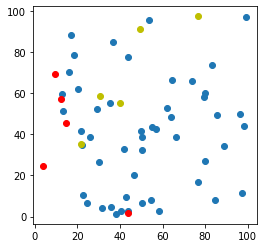

In [61]:
"""
赤がホテル、黄色が避難所
"""
plt.figure(figsize=(4, 4))
plt.plot(x_y[:, 0], x_y[:, 1], 'o')
plt.plot(locations[0:N_h,0],locations[0:N_h,1],"ro")
plt.plot(locations[N_h:,0],locations[N_h:,1],"yo")
#plt.plot((110,0),(0,110))
plt.show()

In [62]:
x = x_y[:, 0]
y = x_y[:, 1]
loc_x = locations[:, 0]
loc_y = locations[:, 1]
#loch_x = locations_h[:, 0]
#loch_y = locations_h[:, 1]

In [63]:
#避難所と住民の距離
di = np.sqrt((x[:, np.newaxis] - loc_x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - loc_y[np.newaxis, :]) ** 2 )
di = di.astype(np.int64)
a = np.zeros((N,1),dtype=np.int64)
di = np.concatenate([a,di],axis=1)

## SCOPで最適化

In [88]:
from scop import *

In [89]:
m = Model()

In [90]:
#場所ごとに危険率を設定
H = np.zeros((N,N_sh+1),dtype=np.int64)
for i in people:
    H[i][0] = np.random.randint(30,40)
H

array([[38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [35,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [37,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [34,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [91]:
#D[k,l]
D = np.zeros((N_sh+1,N_sh+1),dtype=np.int64)
for i in shelters:
    for j in shelters:
        if i == j and i != 0 and j!= 0:
            D[i,j] = 1
        else:
            D[i,j] = 0
D

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [92]:
#W[i,j]
W = np.zeros((N,N),dtype=np.int64)
for i in people:
    for j in people:
        w1 = max(infec_rate[j] - infec_rate[i],0) * mort_rate[i] + max(infec_rate[i] - infec_rate[j],0) * mort_rate[j]
        w2 = abs(infec_rate[j] - infec_rate[i])
        W[i,j] = w1*w2/10
W

array([[  0, 230,   9, ..., 147,   0,  36],
       [230,   0, 152, ...,   0,  10,   1],
       [  9, 152,   0, ...,  85,   0,   9],
       ...,
       [147,   0,  85, ...,   0,   6,   0],
       [  0,  10,   0, ...,   6,   0,   1],
       [ 36,   1,   9, ...,   0,   1,   0]])

### 人iを変数x[i]として、施設kの集合をドメインとする

In [93]:
x={}
for i in people:
    x[i] = m.addVariable(name = 'x[%s]'%i ,domain = shelters)

### 目的関数(二次制約クラスQuadratic)
#### W[i,j] D[k,l] (X[i]=k) (X[j]=l)の合計の最小化

In [94]:
obj = Quadratic('obj',weight = 1 ,
                rhs = 0, direction = '<=')
for i in people:
    for j in people:
        if i != j:
            for k in shelters:
                for l in shelters:
                    obj.addTerms(W[i,j]*D[k,l]+H[i,k],x[i],k,x[j],l)
m.addConstraint(obj)

### 　制約
#### 各避難所に割り振られる人数は、避難所の要領以下


In [95]:
UB = {}
for k in shelters:
    UB[k] = Linear("UB{%s}"%(i),
                   weight = 'inf',
                   rhs= capacity[k],
                   direction = '<=')
    for i in people:
        UB[k].addTerms(1,x[i],k)
    m.addConstraint(UB[k])
#print(m)

In [96]:
#print(m)

In [97]:
m.Params.TimeLimit=1
sol,violated=m.optimize()

#print (m)

print ("solution")
for x in sol:
    print (x,sol[x])
print ("violated constraint(s)")
for v in violated:
    print (v,violated[v])


 ================ Now solving the problem ================ 

solution
x[0] 0
x[1] 0
x[2] 0
x[3] 9
x[4] 7
x[5] 0
x[6] 0
x[7] 0
x[8] 2
x[9] 8
x[10] 0
x[11] 8
x[12] 6
x[13] 0
x[14] 0
x[15] 5
x[16] 9
x[17] 10
x[18] 7
x[19] 10
x[20] 0
x[21] 4
x[22] 9
x[23] 7
x[24] 9
x[25] 10
x[26] 1
x[27] 9
x[28] 9
x[29] 3
x[30] 8
x[31] 10
x[32] 0
x[33] 0
x[34] 0
x[35] 0
x[36] 7
x[37] 9
x[38] 10
x[39] 0
x[40] 0
x[41] 0
x[42] 0
x[43] 9
x[44] 0
x[45] 8
x[46] 8
x[47] 0
x[48] 0
x[49] 7
violated constraint(s)
obj 37131


[21, 1, 1, 1, 1, 1, 1, 5, 5, 8, 5]


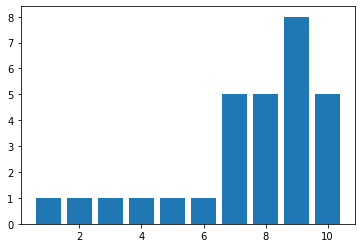

In [98]:
L = [i for i in shelters]
count = {}
L2 = []
for i in L:
    count[i] = 0
for x in sol:
    count[int(sol[x])] +=1
for j in count:
    L2.append(count[j])
import numpy as np
import matplotlib.pyplot as plt
left = L[1:]
height = L2[1:]
plt.bar(left, height)
print(L2)